<b>environment:</b> spatial_env, python=3.13.2

In [14]:
import pandas as pd
import numpy as np
import scanpy as sc

from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils
from cellphonedb.utils import db_utils
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

from scipy.stats import combine_pvalues

import ktplotspy as kpy
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns

from filter_adata import adata_filtered, adata_hightumour, adata_peritumour
from starbars import starbars

from pathlib import Path 
import os

# set path to CellPhoneDB files
CCC_path = '/Users/nabilazulkapeli/Documents/Honours Thesis 2025/nabs_data/CCC'
CCC_path = Path(CCC_path)

In [7]:
# colours and labels for R/NR downstream plotting
# broad cell categories
cell_categories = {
    'Proliferating Melanoma'  : 'Tumour',
    'Inflammatory CAF': 'Stromal',     
    'Epithelial': 'Tumour',               
    'CD8 T': 'Immune',            
    'Endothelial': 'Stromal',                 
    'Granulocyte': 'Immune',                        
    'M2 TAM': 'Immune',                             
    'CD4 T': 'Immune',                     
    'Classical CAF': 'Stromal',
    'Plasma B': 'Immune',              
    'Dendritic': 'Immune',           
    'Plasmablast': 'Immune',        
    'M1 TAM': 'Immune',                 
    'Ig-expressing TAM': 'Immune',      
    'TLS': 'Immune',                  
    'Mast': 'Immune'
}
                       
# colors for categories
category_colors = {
    "Tumour": "#fb8072",
    "Immune": "#bebada",
    "Stromal": "#80b1d3"
}

interaction_map = {
    # cytokines
    'CCL5_CCR4': 'Cytokine',
    'CXCL12_CXCR4': 'Cytokine',
    'CXCL14_CXCR4': 'Cytokine',
    'CCL5_CCR1': 'Cytokine',
    'CCL4_CCR5': 'Cytokine',
    'CCL5_CCR5': 'Cytokine',
    'CXCL13_CXCR5': 'Cytokine',
    'CXCL16_CXCR6': 'Cytokine',
    'CCL14_CCR1': 'Cytokine',
    'CCL8_CCR1': 'Cytokine',
    'CCL8_CCR5': 'Cytokine',
    'CXCL6_CXCR2': 'Cytokine',
    'CCL7_CCR1': 'Cytokine',
    'CCL7_CCR2': 'Cytokine',
    'CCL7_CCR3': 'Cytokine',
    'CCL7_CCR5': 'Cytokine',
    'CCL3_CCR1': 'Cytokine',
    'CCL3_CCR3': 'Cytokine',
    'CCL3_CCR5': 'Cytokine',
    'CCL3L1_CCR1': 'Cytokine',
    'CCL3L1_CCR3': 'Cytokine',
    'CCL5_CCR3': 'Cytokine',
    'CCL8_CCR2': 'Cytokine',
    'CCL8_CCR3': 'Cytokine',
    'CCL13_CCR2': 'Cytokine',
    'CCL13_CCR3': 'Cytokine',
    'CCL14_CCR3': 'Cytokine',
    'CCL15_CCR1': 'Cytokine',
    'CCL15_CCR3': 'Cytokine',
    'CCL16_CCR1': 'Cytokine',
    'CCL16_CCR2': 'Cytokine',
    'CCL19_CCR7': 'Cytokine',
    'CCL20_CCR6': 'Cytokine',
    'CCL21_CCR7': 'Cytokine',
    'CCL26_CCR1': 'Cytokine',
    'CCL26_CCR2': 'Cytokine',
    'CCL26_CCR3': 'Cytokine',
    'CX3CL1_CX3CR1': 'Cytokine',
    'CXCL1_CXCR1': 'Cytokine',
    'CXCL1_CXCR2': 'Cytokine',
    'CXCL2_CXCR2': 'Cytokine',
    'CXCL3_CXCR2': 'Cytokine',
    'CXCL5_CXCR1': 'Cytokine',
    'CXCL5_CXCR2': 'Cytokine',
    'CXCL6_CXCR1': 'Cytokine',
    'CXCL9_CXCR3': 'Cytokine',
    'CXCL10_CXCR3': 'Cytokine',
    'CXCL11_CXCR3': 'Cytokine',
    'CCL2_CCR2': 'Cytokine',
    'CCL11_CCR3': 'Cytokine',
    # interleukins
    'IL1A_IL1_RECEPTOR': 'Cytokine',
    'IL1B_IL1_RECEPTOR': 'Cytokine',
    'IL2_IL2_RECEPTOR_I': 'Cytokine',
    'IL2_IL2_RECEPTOR_HA': 'Cytokine',
    'IL4_IL4_RECEPTOR': 'Cytokine',
    'IL13_IL13RA2': 'Cytokine',
    'IL15_IL15_RECEPTOR': 'Cytokine',

    # T cell
    'CD86_CD28': 'T Cell Activation',
    'CD80_CD28': 'T Cell Activation',
    'LCK_CD8_RECEPTOR': 'TCR Signalling',

    # notch
    'JAG1_NOTCH1': 'Notch',
    'JAG1_NOTCH2': 'Notch',
    'JAG1_NOTCH3': 'Notch',

    # growth factors
    'EGF_EGFR': 'Growth Factor',
    'AREG_EGFR': 'Growth Factor',
    'EPO_EPOR': 'Growth Factor',
    'VEGFA_FLT1': 'Growth Factor',
    'VEGFA_FLT1_COMPLEX': 'Growth Factor',
    'VEGFA_KDR': 'Growth Factor',
    
    'CSF1_CSF1R': 'Growth Factor (Myeloid)',

    # TNF superfamily
    'FASLG_FAS': 'TNF-Family',
    'TNF_TNFRSF1B': 'TNF-Family',
    'CD40LG_CD40': 'TNF-Family',

    # checkpoint
    'CD274_PDCD1': 'Checkpoint',
    'PDCD1LG2_PDCD1': 'Checkpoint',
    'ICOSLG_ICOS': 'Checkpoint',
    'CD48_CD244': 'Checkpoint',
    'CD86_CTLA4': 'Checkpoint',
    'CD80_CTLA4': 'Checkpoint',
    'PVR_TIGIT': 'Checkpoint',
    'PVR_CD96': 'Checkpoint',
    'CD274_CD80': 'Checkpoint',

    # adhesion
    'CEACAM8_CEACAM6': 'Adhesion',
    'CEACAM6_CEACAM6': 'Adhesion',
    'CEACAM1_CEACAM6': 'Adhesion',
    'CEACAM1_CEACAM8': 'Adhesion',
    'ICAM1_INTEGRIN_ALB2_COMPLEX': 'Adhesion',
    'ICAM1_INTEGRIN_AMB2_COMPLEX': 'Adhesion',
    'ICAM1_INTEGRIN_AXB2_COMPLEX': 'Adhesion',
    'FCER2_INTEGRIN_AMB2_COMPLEX': 'Adhesion',
    'FCER2_INTEGRIN_AXB2_COMPLEX': 'Adhesion',
    'ICAM1_ITGAL': 'Adhesion',
    
    'CDH5_CDH5': 'Adhesion (Endothelial)',
}
 
edge_colours = {
    'Cytokine': '#f3d337',
    'T cell activation': '#66b5ae',
    'Checkpoint': '#d7689d',
    'Adhesion':'#5da4dc',
    'Adhesion (Endothelial)': '#40769e',
    'Notch': '#a0c443',
    'Growth Factor': '#d76868',
    'Growth Factor (Myeloid)': '#a53b3b',
    'TCR Signalling': '#179085'
}

In [8]:
def collapse_and_process_pvals(pvals):
    """collapse p-values across cores (fisher method), then filter significant interactions."""
    # melt pvals
    melted = pvals.melt(id_vars=["interacting_pair"], var_name="pair", value_name="pval")
    melted["pval"] = pd.to_numeric(melted["pval"], errors="coerce")
    melted = melted[melted["pair"].str.contains(r"\|", na=False)]
    # collapse across duplicate interaction–pair rows (multiple cores)
    collapsed = (
        melted.groupby(["interacting_pair", "pair"])["pval"]
        .apply(lambda vals: (
            combine_pvalues(
                np.clip(vals.dropna().values, 1e-300, 1.0),  # avoid log(0)
                method="fisher"
            )[1]
            if vals.notna().any() else np.nan
        ))
        .reset_index()
    )
    # filter significant pvals only
    sig = collapsed[collapsed["pval"] < 0.05].copy()
    # split cell types
    sig[["cell1", "cell2"]] = sig["pair"].str.split(r"\|", expand=True)
    # drop core IDs, keep only base cell types
    sig["cell1_base"] = sig["cell1"].str.split("::").str[0]
    sig["cell2_base"] = sig["cell2"].str.split("::").str[0]
    return sig

<h1><b>Global Analysis

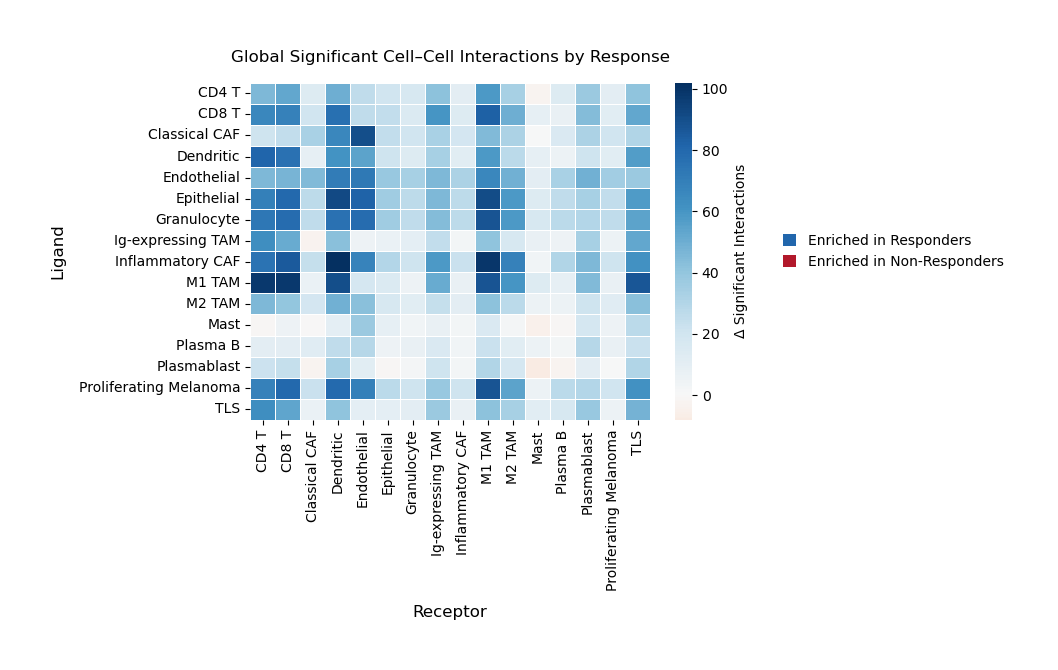

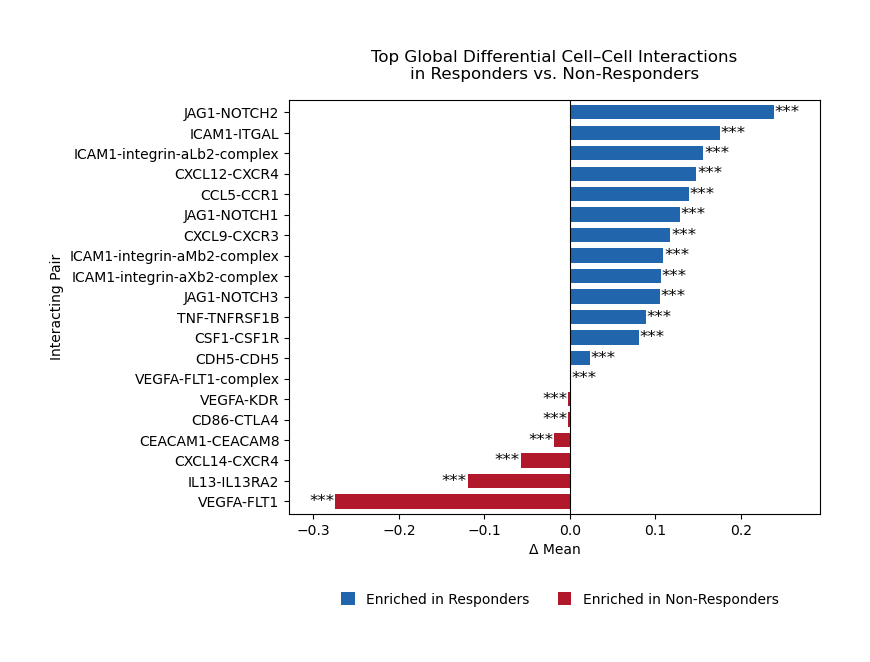

In [15]:
pvals_R = pd.read_csv(os.path.join(CCC_path, 'global', 'R', 'statistical_analysis_pvalues_09_05_2025_142450.txt'), sep='\t')
pvals_NR = pd.read_csv(os.path.join(CCC_path, 'global', 'NR', 'statistical_analysis_pvalues_09_05_2025_142846.txt'), sep='\t')

sig_R = collapse_and_process_pvals(pvals_R)
sig_NR = collapse_and_process_pvals(pvals_NR)

counts_R = sig_R.groupby(["cell1_base", "cell2_base"]).size().unstack(fill_value=0)
counts_NR = sig_NR.groupby(["cell1_base", "cell2_base"]).size().unstack(fill_value=0)

# subtract counts to find difference in significant interactions
diff_counts = counts_R - counts_NR

# heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(diff_counts, cmap="RdBu", center=0, linewidths=0.5,
            cbar_kws={"label":"Δ Significant Interactions"})

plt.title("Global Significant Cell–Cell Interactions by Response", pad=15)
ax.set_xlabel("Receptor", fontsize=12, labelpad=10)
ax.set_ylabel("Ligand", fontsize=12, labelpad=10)

# legend
red_patch = mpatches.Patch(color="#2166ac", label="Enriched in Responders")
blue_patch = mpatches.Patch(color="#b2182b", label="Enriched in Non-Responders")
plt.legend(
    handles=[red_patch, blue_patch],
    loc="center left",
    bbox_to_anchor=(1.3, 0.5),    # move below the axis
    ncol=1                       # 2 columns                  
)
plt.tight_layout()

# load means and pvals
means_R = pd.read_csv(os.path.join(CCC_path, "global", "R", "statistical_analysis_means_09_05_2025_142450.txt"), sep="\t")
means_NR = pd.read_csv(os.path.join(CCC_path, "global", "NR", "statistical_analysis_means_09_05_2025_142846.txt"), sep="\t")

# set index for means tables
means_R = means_R.set_index("interacting_pair")
means_NR = means_NR.set_index("interacting_pair")

# get rid of core names (cell1::cell2 -> cell1|cell2)
means_R.columns = [col.split("::")[0] if "::" in col else col for col in means_R.columns]
means_NR.columns = [col.split("::")[0] if "::" in col else col for col in means_NR.columns]

# convert to numeric
means_R = means_R.select_dtypes(include=[np.number])
means_NR = means_NR.select_dtypes(include=[np.number])

# align R/NR
means_R, means_NR = means_R.align(means_NR, join="inner", axis=1)

# subtraction
diff_means = means_R - means_NR
interaction_diffs = diff_means.abs().max(axis=1).sort_values(ascending=False)

# top 20 interaction pairs
top20_pairs = interaction_diffs.head(20).index
top20_diff = diff_means.loc[top20_pairs]
top20_diff_mean = top20_diff.mean(axis=1).sort_values()
top20_diff_mean.index = top20_diff_mean.index.astype(str).str.replace("_", "-", regex=False)

collapsed_R = collapse_and_process_pvals(pvals_R)
collapsed_NR = collapse_and_process_pvals(pvals_NR)
collapsed_R = collapsed_R.groupby("interacting_pair")["pval"].min()
collapsed_NR = collapsed_NR.groupby("interacting_pair")["pval"].min()

collapsed_pvals = pd.concat([collapsed_R, collapsed_NR], axis=1).min(axis=1)
collapsed_pvals.index = collapsed_pvals.index.astype(str).str.replace("_", "-", regex=False)
collapsed_pvals = collapsed_pvals.groupby(level=0).min()
collapsed_pvals = collapsed_pvals.reindex(top20_diff_mean.index)

stars = collapsed_pvals.apply(starbars)

# horizontal bar plot
plt.figure(figsize=(8, 6))
top20_diff_mean.plot(
    kind="barh",
    width=0.7,
    color=["#b2182b" if x < 0 else "#2166ac" for x in top20_diff_mean]
)
plt.axvline(0, color="black", linewidth=0.8)

# expand x-axis
xmin, xmax = plt.gca().get_xlim()
plt.xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin))

# overlay stars
for i, (idx, val) in enumerate(top20_diff_mean.items()):
    star = stars.loc[idx]
    if star != "":
        if val > 0:
            plt.text(val + 0.001, i, star, va="center", ha="left", fontsize=12)
        else:
            plt.text(val - 0.001, i, star, va="center", ha="right", fontsize=12)

# legend
nr_patch = mpatches.Patch(color="#b2182b", label="Enriched in Non-Responders")
r_patch = mpatches.Patch(color="#2166ac", label="Enriched in Responders")
plt.legend(
    handles=[r_patch, nr_patch],
    loc="upper center",
    bbox_to_anchor=(0.51, -0.16),
    ncol=2,
    frameon=True
)

plt.title("Top Global Differential Cell–Cell Interactions\nin Responders vs. Non-Responders", pad=15)
plt.xlabel("Δ Mean")
plt.ylabel("Interacting Pair")
plt.tight_layout()

<h1><b>High Tumour Analysis

In [ ]:
pvals_R = pd.read_csv(os.path.join(CCC_path, 'ht', 'R', 'statistical_analysis_pvalues_09_05_2025_153947.txt'), sep='\t')
pvals_NR = pd.read_csv(os.path.join(CCC_path, 'ht', 'NR', 'statistical_analysis_pvalues_09_05_2025_154135.txt'), sep='\t')

sig_R = collapse_and_process_pvals(pvals_R)
sig_NR = collapse_and_process_pvals(pvals_NR)

counts_R = sig_R.groupby(["cell1_base", "cell2_base"]).size().unstack(fill_value=0)
counts_NR = sig_NR.groupby(["cell1_base", "cell2_base"]).size().unstack(fill_value=0)

# subtract counts to find difference in significant interactions
diff_counts = counts_R - counts_NR

# heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(diff_counts, cmap="RdBu", center=0, linewidths=0.5,
            cbar_kws={"label":"Δ Significant Interactions"})

plt.title("Global Significant Cell–Cell Interactions by Response", pad=15)
ax.set_xlabel("Receptor", fontsize=12, labelpad=10)
ax.set_ylabel("Ligand", fontsize=12, labelpad=10)

# legend
red_patch = mpatches.Patch(color="#2166ac", label="Enriched in Responders")
blue_patch = mpatches.Patch(color="#b2182b", label="Enriched in Non-Responders")
plt.legend(
    handles=[red_patch, blue_patch],
    loc="center left",
    bbox_to_anchor=(1.3, 0.5),    # move below the axis
    ncol=1                       # 2 columns                  
)
plt.tight_layout()

# load means and pvals
means_R = pd.read_csv(os.path.join(CCC_path, "ht", "R", "statistical_analysis_means_09_05_2025_153947.txt"), sep="\t")
means_NR = pd.read_csv(os.path.join(CCC_path, "ht", "NR", "statistical_analysis_means_09_05_2025_154135.txt"), sep="\t")

# set index for means tables
means_R = means_R.set_index("interacting_pair")
means_NR = means_NR.set_index("interacting_pair")

# get rid of core names (cell1::cell2 -> cell1|cell2)
means_R.columns = [col.split("::")[0] if "::" in col else col for col in means_R.columns]
means_NR.columns = [col.split("::")[0] if "::" in col else col for col in means_NR.columns]

# convert to numeric
means_R = means_R.select_dtypes(include=[np.number])
means_NR = means_NR.select_dtypes(include=[np.number])

# align R/NR
means_R, means_NR = means_R.align(means_NR, join="inner", axis=1)

# subtraction
diff_means = means_R - means_NR
interaction_diffs = diff_means.abs().max(axis=1).sort_values(ascending=False)

# top 20 interaction pairs
top20_pairs = interaction_diffs.head(20).index
top20_diff = diff_means.loc[top20_pairs]
top20_diff_mean = top20_diff.mean(axis=1).sort_values()
top20_diff_mean.index = top20_diff_mean.index.astype(str).str.replace("_", "-", regex=False)

collapsed_R = collapse_and_process_pvals(pvals_R)
collapsed_NR = collapse_and_process_pvals(pvals_NR)
collapsed_R = collapsed_R.groupby("interacting_pair")["pval"].min()
collapsed_NR = collapsed_NR.groupby("interacting_pair")["pval"].min()

collapsed_pvals = pd.concat([collapsed_R, collapsed_NR], axis=1).min(axis=1)
collapsed_pvals.index = collapsed_pvals.index.astype(str).str.replace("_", "-", regex=False)
collapsed_pvals = collapsed_pvals.groupby(level=0).min()
collapsed_pvals = collapsed_pvals.reindex(top20_diff_mean.index)

stars = collapsed_pvals.apply(starbars)

# horizontal bar plot
plt.figure(figsize=(8, 6))
top20_diff_mean.plot(
    kind="barh",
    width=0.7,
    color=["#b2182b" if x < 0 else "#2166ac" for x in top20_diff_mean]
)
plt.axvline(0, color="black", linewidth=0.8)

# expand x-axis
xmin, xmax = plt.gca().get_xlim()
plt.xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin))

# overlay stars
for i, (idx, val) in enumerate(top20_diff_mean.items()):
    star = stars.loc[idx]
    if star != "":
        if val > 0:
            plt.text(val + 0.001, i, star, va="center", ha="left", fontsize=12)
        else:
            plt.text(val - 0.001, i, star, va="center", ha="right", fontsize=12)

# legend
nr_patch = mpatches.Patch(color="#b2182b", label="Enriched in Non-Responders")
r_patch = mpatches.Patch(color="#2166ac", label="Enriched in Responders")
plt.legend(
    handles=[r_patch, nr_patch],
    loc="upper center",
    bbox_to_anchor=(0.51, -0.16),
    ncol=2,
    frameon=True
)

plt.title("Top Intratumoural Differential Cell–Cell Interactions\nin Responders vs. Non-Responders", pad=15)
plt.xlabel("Δ Mean")
plt.ylabel("Interacting Pair")
plt.tight_layout()

<h1><b>Peritumour Analysis

In [ ]:
pvals_R = pd.read_csv(os.path.join(CCC_path, 'peri', 'R', 'statistical_analysis_pvalues_09_05_2025_152301.txt'), sep='\t')
pvals_NR = pd.read_csv(os.path.join(CCC_path, 'peri', 'NR', 'statistical_analysis_pvalues_09_05_2025_152935.txt'), sep='\t')

sig_R = collapse_and_process_pvals(pvals_R)
sig_NR = collapse_and_process_pvals(pvals_NR)

counts_R = sig_R.groupby(["cell1_base", "cell2_base"]).size().unstack(fill_value=0)
counts_NR = sig_NR.groupby(["cell1_base", "cell2_base"]).size().unstack(fill_value=0)

# subtract counts to find difference in significant interactions
diff_counts = counts_R - counts_NR

# heatmap
plt.figure(figsize=(10,6))
ax = sns.heatmap(diff_counts, cmap="RdBu", center=0, linewidths=0.5,
            cbar_kws={"label":"Δ Significant Interactions"})

plt.title("Global Significant Cell–Cell Interactions by Response", pad=15)
ax.set_xlabel("Receptor", fontsize=12, labelpad=10)
ax.set_ylabel("Ligand", fontsize=12, labelpad=10)

# legend
red_patch = mpatches.Patch(color="#2166ac", label="Enriched in Responders")
blue_patch = mpatches.Patch(color="#b2182b", label="Enriched in Non-Responders")
plt.legend(
    handles=[red_patch, blue_patch],
    loc="center left",
    bbox_to_anchor=(1.3, 0.5),    # move below the axis
    ncol=1                       # 2 columns                  
)
plt.tight_layout()

# load means and pvals
means_R = pd.read_csv(os.path.join(CCC_path, "peri", "R", "statistical_analysis_means_09_05_2025_152301.txt"), sep="\t")
means_NR = pd.read_csv(os.path.join(CCC_path, "peri", "NR", "statistical_analysis_means_09_05_2025_152935.txt"), sep="\t")

# set index for means tables
means_R = means_R.set_index("interacting_pair")
means_NR = means_NR.set_index("interacting_pair")

# get rid of core names (cell1::cell2 -> cell1|cell2)
means_R.columns = [col.split("::")[0] if "::" in col else col for col in means_R.columns]
means_NR.columns = [col.split("::")[0] if "::" in col else col for col in means_NR.columns]

# convert to numeric
means_R = means_R.select_dtypes(include=[np.number])
means_NR = means_NR.select_dtypes(include=[np.number])

# align R/NR
means_R, means_NR = means_R.align(means_NR, join="inner", axis=1)

# subtraction
diff_means = means_R - means_NR
interaction_diffs = diff_means.abs().max(axis=1).sort_values(ascending=False)

# top 20 interaction pairs
top20_pairs = interaction_diffs.head(20).index
top20_diff = diff_means.loc[top20_pairs]
top20_diff_mean = top20_diff.mean(axis=1).sort_values()
top20_diff_mean.index = top20_diff_mean.index.astype(str).str.replace("_", "-", regex=False)

collapsed_R = collapse_and_process_pvals(pvals_R)
collapsed_NR = collapse_and_process_pvals(pvals_NR)
collapsed_R = collapsed_R.groupby("interacting_pair")["pval"].min()
collapsed_NR = collapsed_NR.groupby("interacting_pair")["pval"].min()

collapsed_pvals = pd.concat([collapsed_R, collapsed_NR], axis=1).min(axis=1)
collapsed_pvals.index = collapsed_pvals.index.astype(str).str.replace("_", "-", regex=False)
collapsed_pvals = collapsed_pvals.groupby(level=0).min()
collapsed_pvals = collapsed_pvals.reindex(top20_diff_mean.index)

stars = collapsed_pvals.apply(starbars)

# horizontal bar plot
plt.figure(figsize=(8, 6))
top20_diff_mean.plot(
    kind="barh",
    width=0.7,
    color=["#b2182b" if x < 0 else "#2166ac" for x in top20_diff_mean]
)
plt.axvline(0, color="black", linewidth=0.8)

# expand x-axis
xmin, xmax = plt.gca().get_xlim()
plt.xlim(xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin))

# overlay stars
for i, (idx, val) in enumerate(top20_diff_mean.items()):
    star = stars.loc[idx]
    if star != "":
        if val > 0:
            plt.text(val + 0.001, i, star, va="center", ha="left", fontsize=12)
        else:
            plt.text(val - 0.001, i, star, va="center", ha="right", fontsize=12)

# legend
nr_patch = mpatches.Patch(color="#b2182b", label="Enriched in Non-Responders")
r_patch = mpatches.Patch(color="#2166ac", label="Enriched in Responders")
plt.legend(
    handles=[r_patch, nr_patch],
    loc="upper center",
    bbox_to_anchor=(0.51, -0.16),
    ncol=2,
    frameon=True
)

plt.title("Top Intratumoural Differential Cell–Cell Interactions\nin Responders vs. Non-Responders", pad=15)
plt.xlabel("Δ Mean")
plt.ylabel("Interacting Pair")
plt.tight_layout()